# Skimlit 📃
The purpose of this project is to build NLP model to make reading of medical abstracts easier.

The paper we are replicating (source of dataset in available at https://arxiv.org/abs/1710.06071)

and The model arcitucture they used to achive their best results is avilable at https://arxiv.org/abs/1612.05251


## Confirm GPU access

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5dacae4b-4259-fdc5-aff3-f3d5d832114c)


## Getting the data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct/

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 22.97 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# checking the files in smaller dataset (pubmed 20k)
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/


dev.txt  test.txt  train.txt


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Checking all filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Helper function


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [ ]:
def pretefch_dataset(data_tuple,label):
  data = tf.data.Dataset.from_tensor_slices(data_tuple)
  labels = tf.data.Dataset.from_tensor_slices(label)
  dataset = tf.data.Dataset.zip((data, labels))

  # Prefetch and batch data
  final_dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

  return final_dataset

In [ ]:
import tensorflow as tf
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Preprocessing data
to visualize the data i will create a function to read all the lines in target txt file

In [ ]:
# function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of a text as a list.

  Args:
     filename : String containing the target filepath.

  Returns:
     A List of strings with one string per line from the target filename.
  """
  with open(filename ,"r") as f:
    return f.readlines()

In [ ]:
# Reading training lines
train_lines = get_lines(filenames[0])
train_lines[:20]


['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

The format the i see it best fits the problem to transform the data in this format
```
[{
    'line_number':0,
    'target': 'BACKGROUND',
    'text' : 'Emotional eating is associated with overeating and the development of obesity .\n'
    'total_lines' : 11
}]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a List of dictionaries of abstract line data

  Takes in filename, reads its contents and sorts through each line,
  etracting things like thetarget label, the tet of the sentence,
  how many sentences are in the current abstract and what sentence number the target line is.
  """

  input_lines = get_lines(filename)
  abstract_lines= "" # create empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith("###"):# check to see if the line is an ID line
      abstract_id = line
      abstract_lines= "" # reset the abstract string if the line is ID line
    elif line.isspace(): # check to see if the line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into a separate lines

      #Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data= {} # create empty dictionary for each line
        target_text_split = abstract_line.split("\t") #split target label from text
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1 # total number of lines as we start from zero
        abstract_samples.append(line_data)
    else: # if the line is not ID or \n then the line is a laelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
## testing on train data
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 653 ms, sys: 138 ms, total: 791 ms
Wall time: 1.14 s


In [ ]:
# checking the first abstract of the training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

 Turning the dictionary into a dataframe to further visualize it.

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

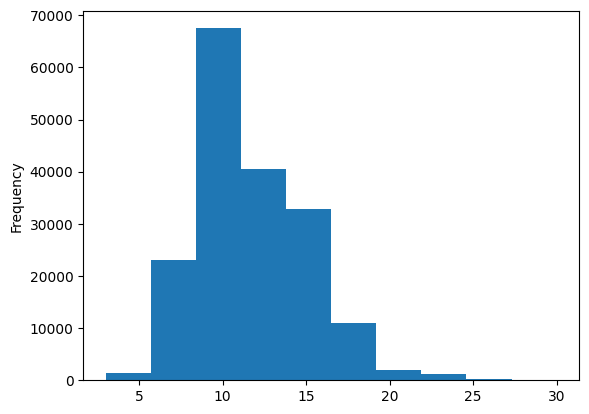

In [ ]:
# length of diffrent lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [ ]:
# convert abstract test lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# view the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make Numeric labels

In [ ]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # as tensorflow is not compatitble with sparse mat.
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into Intege rs
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modeling Expriments

### Model 0 : baseline TF-IDF Multinomial Naive Bayes classifer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#pipeline
model_0 = Pipeline(
    [("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())]
)

# fit pipeline to training data
model_0.fit(X= train_sentences,
            y= train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluating baseline on validation data
model_0.score(X= val_sentences,
            y= val_labels_encoded)

0.7218323844829869

In [ ]:
# Making some predections
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# calculating baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred= baseline_preds)

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing the text for deep sequence models "Vectorization and embedding"

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# The average length of the sentences
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

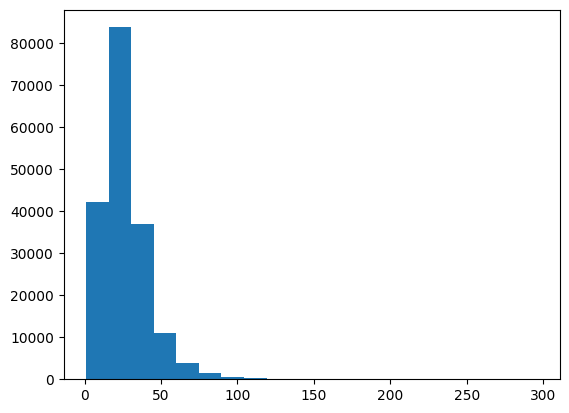

In [ ]:
# The distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins =20);

In [ ]:
# how long of a sentence length covers 95% of examples? in order to detect the correct tokenizer length
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
# max sequence length  in training set
max(sent_lens)

296

#### Vectorization

since i use pubmed 20K it's stated in the paper that the vocabulary size is 68K

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68000

text_vectorizer = TextVectorization(
    max_tokens= max_tokens, # vocabulary size
    output_sequence_length= output_seq_len #desired output length if the vectorized sentences
)

In [ ]:
# adapting text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Testing the vectorizer on a random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized version : {text_vectorizer([target_sentence])}")

Text:
 in a double-blind , placebo-controlled eye-tracking study , we assessed the effect of single dose of citalopram ( @mg ) in @ healthy females .

Length of text: 142

Vectorized version : [[    5     8   236   329 31370    17    43   113     2    70     4   312
    131     4  4336    68     5   247  1188     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# Checking out the number of words in the training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# configuration of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#### Custom text embedding

In [ ]:
token_embed = layers.Embedding(
    input_dim= len(rct_20k_text_vocab),
    output_dim=128,
    mask_zero= True, # masking is to handle variable sequence lengths (optimization "saves space")
    name = "token_embedding"
)

In [ ]:
# testing out
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding)\n: {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding\n: {embedded_sentence}\n")
print(f"\nEmbedded sentnece shape: {embedded_sentence.shape}")

Sentence before vectorization:
 in a double-blind , placebo-controlled eye-tracking study , we assessed the effect of single dose of citalopram ( @mg ) in @ healthy females .

Sentence after vectorization (before embedding)
: [[    5     8   236   329 31370    17    43   113     2    70     4   312
    131     4  4336    68     5   247  1188     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding
: [[[ 0.00653359  0.04650043 -0.02775974 ... -0.00465067 -0.04083403
   -0.00715758]
  [ 0.01596791  0.01021321 -0.04574039 ... -0.02016318 -0.00846358
   -0.03522606]
  [ 0.02054917 -0.03626852 -0.02632372 ... -0.00675113 -0.04315933
    0.01855941]
  ...
  [-0.00735713  0.0426405   0.0200279  ...  0.02020624  0.04849858
    0.02192685]
  [-0.00735713  0.0426405   0.0200279  ...  0.02020624  0.04849858

### Creating Datasets (to make sure that data loads as fast as possible)

Using tf.data API

In [ ]:
# turining the data into prefetched and batched datasets tp be accssed faster by GPU
train_dataset = pretefch_dataset(train_sentences,train_labels_one_hot)
valid_dataset =pretefch_dataset(val_sentences,val_labels_one_hot)
test_dataset = pretefch_dataset(test_sentences,test_labels_one_hot)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv 1D with embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 20s 30ms/step - loss: 0.9290 - accuracy: 0.6323 - val_loss: 0.6932 - val_accuracy: 0.7357
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6622 - accuracy: 0.7517 - val_loss: 0.6314 - val_accuracy: 0.7729
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6199 - accuracy: 0.7711 - val_loss: 0.5993 - val_accuracy: 0.7826


In [ ]:
# Evaluate on whole validation
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6012 - accuracy: 0.7850


[0.6011954545974731, 0.7849860787391663]

In [ ]:
# Make preds [model makes a prediction for each class "Multiclass"]
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs,  model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.24047172e-01, 1.58337176e-01, 6.81937560e-02, 3.28366786e-01,
         2.10551489e-02],
        [4.81937617e-01, 2.35417619e-01, 1.35891186e-02, 2.62437999e-01,
         6.61770254e-03],
        [1.72440827e-01, 8.65067355e-03, 1.38421077e-03, 8.17492843e-01,
         3.14661265e-05],
        ...,
        [4.63608694e-06, 5.50015306e-04, 6.78240263e-04, 3.05628146e-06,
         9.98764038e-01],
        [5.61432429e-02, 3.98644507e-01, 1.21152416e-01, 7.34942853e-02,
         3.50565553e-01],
        [1.60514250e-01, 7.10346580e-01, 3.68492492e-02, 4.30754535e-02,
         4.92144637e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculating model_1 results
model_1_results = calculate_results(y_true= val_labels_encoded, y_pred= model_1_preds)
model_1_results

{'accuracy': 78.49860982391102,
 'precision': 0.7815826363627796,
 'recall': 0.7849860982391103,
 'f1': 0.7823431237583187}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Model 2: Feature extraction with Pretrained token embeddings

In [ ]:
# Using Universal sentence encoder [USE]
import tensorflow_hub as hub
USE = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
## Testing embeddings randomlly
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence Text :\n {random_train_sentence}\n")
USE_embedded_sentence = USE([random_train_sentence])
print(f"Sentence after embedding\n: {USE_embedded_sentence[0][:20]}\n")
print(f"Length of Sentence embedding\n: {len(USE_embedded_sentence[0])}\n")

Random Sentence Text :
 it highlights potentially important correlates of physical activity that could be the focus of interventions targeting rural populations , and demonstrates the need to examine rural adults separately from their urban counterparts .

Sentence after embedding
: [-0.06291871  0.07157428 -0.04574411 -0.01630678 -0.00965894 -0.0146317
  0.03204843  0.01032489 -0.06741539  0.04930262  0.03841316 -0.01148148
  0.04482156  0.02020045  0.01713021 -0.02967998 -0.06708095  0.03994769
  0.01847755 -0.07264812]

Length of Sentence embedding
: 512



In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
embeddings = USE(tf.squeeze(inputs))
x=layers.Dense(128,activation="relu")(embeddings)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs, name="USE_feature_extractor")

#compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 tf.compat.v1.squeeze (TFOp  None                      0         
 Lambda)                                                         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data= valid_dataset,
                              validation_steps= int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 14ms/step - loss: 0.9164 - accuracy: 0.6487 - val_loss: 0.7977 - val_accuracy: 0.6872
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7699 - accuracy: 0.7009 - val_loss: 0.7562 - val_accuracy: 0.7074
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7535 - accuracy: 0.7114 - val_loss: 0.7412 - val_accuracy: 0.7078


In [ ]:
# Evaluate on validation
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.7429 - accuracy: 0.7129


[0.7428667545318604, 0.7128624320030212]

In [ ]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[0.4355566 , 0.3619127 , 0.00255443, 0.18990938, 0.0100669 ],
       [0.33569756, 0.49784112, 0.00427527, 0.15881535, 0.00337067],
       [0.24616235, 0.14925355, 0.02075986, 0.53604287, 0.04778139],
       ...,
       [0.00225989, 0.00554214, 0.05567491, 0.00115446, 0.9353686 ],
       [0.00402193, 0.04559226, 0.2051887 , 0.00137876, 0.7438183 ],
       [0.17600435, 0.21886557, 0.5345962 , 0.00654047, 0.06399339]],
      dtype=float32)

In [ ]:
# finding the correct class using argmax
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# calculating model2 results
model_2_results = calculate_results(y_true = val_labels_encoded, y_pred=model_2_preds)
model_2_results

{'accuracy': 71.28624387660533,
 'precision': 0.7134529769008753,
 'recall': 0.7128624387660533,
 'f1': 0.710007353519698}

### Model 3 : Conv 1D with charcter embeddings

In [ ]:
# creating a charcter level tokenizer
def split_chars(text):
   return " ".join(list(text))

In [ ]:
# testing func
split_chars(random_train_sentence)

'i t   h i g h l i g h t s   p o t e n t i a l l y   i m p o r t a n t   c o r r e l a t e s   o f   p h y s i c a l   a c t i v i t y   t h a t   c o u l d   b e   t h e   f o c u s   o f   i n t e r v e n t i o n s   t a r g e t i n g   r u r a l   p o p u l a t i o n s   ,   a n d   d e m o n s t r a t e s   t h e   n e e d   t o   e x a m i n e   r u r a l   a d u l t s   s e p a r a t e l y   f r o m   t h e i r   u r b a n   c o u n t e r p a r t s   .'

In [ ]:
# splitting sequence-level data splits into charcter-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
# Finding out the avg charcter length in each sentence
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

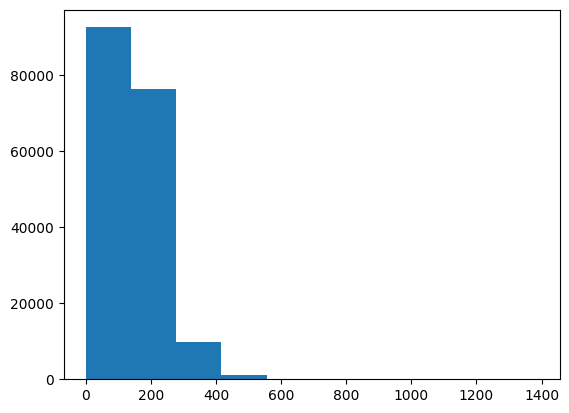

In [ ]:
# checking distribution
plt.hist(char_lens, bins =10);

In [ ]:
# using numpy percentile to find the avg char for 95% of the data
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
# Getting all keyboard charcters to be as the vocab size
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# creating char level token vectorizer
NUM_CHAR_TOKENS = len(alphabet)+ 2 #one for space and the other for OOV token"out of vocab ["UNK"]"

char_vectorizer = TextVectorization(
    max_tokens= NUM_CHAR_TOKENS, # vocabulary size
    output_sequence_length= output_seq_char_len,#desired output length if the vectorized chars
    name = "char_vectorizer"
)

In [ ]:
# Adapting to train chars
char_vectorizer.adapt(train_chars)

In [ ]:
# investigating char vocab
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of Vocab chars : {len(char_vocab)}")
print(f"Most common chars in Vocab : {char_vocab[:5]}")
print(f"Least common chars in Vocab : {char_vocab[-5:]}")

Number of Vocab chars : 28
Most common chars in Vocab : ['', '[UNK]', 'e', 't', 'i']
Least common chars in Vocab : ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Testing out char vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified Text :\n {random_train_chars}")
print(f"Length of random train chars :\n {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars :\n {vectorized_chars}")
print(f"Length of Vectorized chars :\n {len(vectorized_chars[0])}")

Charified Text :
 n e u r o p a t h i c   s y m p t o m s   a n d   e l e c t r o m y o g r a p h y   m e a s u r e m e n t s   d i d   n o t   d i f f e r   b e t w e e n   t w o   g r o u p s   a f t e r   t h e   t r i a l   .
Length of random train chars :
 92
Vectorized chars :
 [[ 6  2 16  8  7 14  5  3 13  4 11  9 19 15 14  3  7 15  9  5  6 10  2 12
   2 11  3  8  7 15 19  7 18  8  5 14 13 19 15  2  5  9 16  8  2 15  2  6
   3  9 10  4 10  6  7  3 10  4 17 17  2  8 22  2  3 20  2  2  6  3 20  7
  18  8  7 16 14  9  5 17  3  2  8  3 13  2  3  8  4  5 12  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [ ]:
# Making embedding layer
char_embed = layers.Embedding(
    input_dim= len(char_vocab),
    output_dim=25, # this is the size of char of the paper : https://arxiv.org/1612.05251.pdf(fig 1)
    mask_zero= True, # masking is to handle variable sequence lengths (optimization "saves space")
    name = "char_embedding"
)

In [ ]:
# testing out
print(f"Charified Text before vectorization:\n {random_train_chars}\n")
vectorized_chars = char_vectorizer([random_train_chars])
embedded_chars = char_embed(vectorized_chars)
print(f"Charified Text  after vectorization and embedding \n: {embedded_chars}\n")
print(f"Embedded Charified Text shape: {embedded_chars.shape}")

Charified Text before vectorization:
 n e u r o p a t h i c   s y m p t o m s   a n d   e l e c t r o m y o g r a p h y   m e a s u r e m e n t s   d i d   n o t   d i f f e r   b e t w e e n   t w o   g r o u p s   a f t e r   t h e   t r i a l   .

Charified Text  after vectorization and embedding 
: [[[-0.02043192  0.0414539  -0.01951951 ...  0.02005139 -0.04233316
   -0.01086231]
  [-0.01252235 -0.0100174   0.00713916 ...  0.01256945  0.0060875
   -0.04025788]
  [-0.02657691  0.01117684 -0.04789896 ... -0.01077287 -0.0160401
    0.00669825]
  ...
  [-0.00273336  0.0333319   0.00429584 ...  0.01863969  0.01735333
    0.04452706]
  [-0.00273336  0.0333319   0.00429584 ...  0.01863969  0.01735333
    0.04452706]
  [-0.00273336  0.0333319   0.00429584 ...  0.01863969  0.01735333
    0.04452706]]]

Embedded Charified Text shape: (1, 290, 25)


In [ ]:
# Model 3
inputs = layers.Input(shape=(1,), dtype=tf.string )
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64,kernel_size=5,padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs, name= "Model_3_conv1D_char_embeddings")
#compile
model_3.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "Model_3_conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# creating prefetched batched char level datasets
train_char_dataset = pretefch_dataset(train_chars,train_labels_one_hot)
val_char_dataset= pretefch_dataset(val_chars,val_labels_one_hot)
test_char_dataset = pretefch_dataset(test_chars,test_labels_one_hot)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fitting the model
model_3_history = model_3.fit(train_char_dataset,
            steps_per_epoch=int(0.1*len(train_char_dataset)),
            epochs=3,
            validation_data=val_char_dataset ,
            validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2514 - accuracy: 0.4982 - val_loss: 1.0397 - val_accuracy: 0.5898
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0036 - accuracy: 0.5980 - val_loss: 0.9391 - val_accuracy: 0.6257
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9267 - accuracy: 0.6362 - val_loss: 0.8666 - val_accuracy: 0.6725


In [ ]:
# evaluate on validation
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8801 - accuracy: 0.6562


[0.8801448345184326, 0.6562293171882629]

In [ ]:
# making predictions
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.10921182, 0.34377152, 0.10895324, 0.3707553 , 0.06730808],
       [0.39339215, 0.41006023, 0.01354717, 0.14665231, 0.03634814],
       [0.13029298, 0.34119445, 0.20043942, 0.2660419 , 0.06203125],
       ...,
       [0.02808617, 0.04291427, 0.18517014, 0.03099386, 0.71283555],
       [0.02836894, 0.15092736, 0.2848811 , 0.02519282, 0.5106298 ],
       [0.47550932, 0.2744871 , 0.1373173 , 0.093077  , 0.01960933]],
      dtype=float32)

In [ ]:
# Getting the correct class using argmax
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 0])>

In [ ]:
# getting model3 results
model_3_results = calculate_results(y_true=val_labels_encoded, y_pred=model_3_preds)
model_3_results

{'accuracy': 65.62293128558188,
 'precision': 0.6454583847741503,
 'recall': 0.6562293128558189,
 'f1': 0.6447321686045726}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Model 4 : Combining pretrained token embeddings + characters embeddings (hybrid embeddings layer)

steps :
1. creating a token-level model (similar to `model 1`)
2. creating a char-level model (similar to `model 3`)
3. combining 1 & 2 with concatenate (`layers.concatenate`)
4. building a series of output layers on top of 3 simillar to Fig 1 and section 4.2 of  https://arxiv.org/pdf/1612.05251.pdf
5. constructing a model which takestoken and character-level sequences as input and produces sequence label probabilites as output

In [ ]:
# 1. token inputs model
token_inputs = layers.Input(shape=[],  dtype=tf.string, name= "token_input")
token_embeddings = USE(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_output)

#2. char inputs model
char_inputs = layers.Input(shape=(1,), dtype= tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # shown in Fig 1 in the paper
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. concatinating token and char inputs [hybrid token emedding]
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4.creating output layers - adding in dropout discussed in section 4.2 of the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. construct model with char and token inputs
model_4= tf.keras.Model(inputs = [token_model.input, char_model.input],
                        outputs= output_layer,
                        name="model_4_token_and_char_embeddings")

In [ ]:
# Model 4 summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

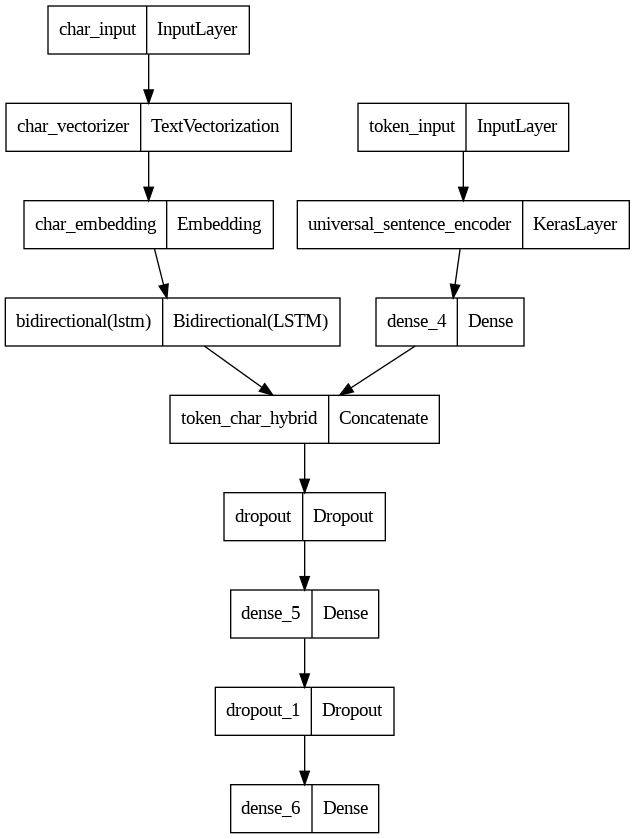

In [ ]:
# Visualizing the model
from keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile
model_4.compile(loss="categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [ ]:
# combining token and character data into a prefetched and batched dayaset for training  and validation datasets
train_token_char_dataset = pretefch_dataset((train_sentences,train_chars),train_labels_one_hot)
val_token_char_dataset = pretefch_dataset((val_sentences,val_chars),val_labels_one_hot)

In [ ]:
# fitting the model
model_4_history = model_4.fit(train_token_char_dataset,
                              steps_per_epoch=int(0.1*len(train_token_char_dataset)),
                              epochs = 3,
                              validation_data= val_token_char_dataset,
                              validation_steps= int(0.1*len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 50ms/step - loss: 0.9758 - accuracy: 0.6082 - val_loss: 0.7839 - val_accuracy: 0.6961
Epoch 2/3
562/562 [==============================] - 25s 45ms/step - loss: 0.8003 - accuracy: 0.6899 - val_loss: 0.7120 - val_accuracy: 0.7291
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.7812 - accuracy: 0.7042 - val_loss: 0.6977 - val_accuracy: 0.7344


In [ ]:
# evaluating
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.7025 - accuracy: 0.7325


[0.7024646401405334, 0.732523500919342]

In [ ]:
# making predections
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_pred_probs

945/945 [==============================] - 20s 18ms/step


array([[3.94489467e-01, 4.15295392e-01, 5.16367983e-03, 1.79190382e-01,
        5.86106768e-03],
       [3.71492028e-01, 4.51260269e-01, 7.32202269e-03, 1.67384997e-01,
        2.54069665e-03],
       [2.89564461e-01, 1.56547457e-01, 3.81762087e-02, 4.89741802e-01,
        2.59700604e-02],
       ...,
       [1.34955056e-03, 1.57966185e-02, 6.99429885e-02, 2.45487259e-04,
        9.12665427e-01],
       [1.02423625e-02, 9.92655307e-02, 2.31778800e-01, 3.74389137e-03,
        6.54969394e-01],
       [3.43421459e-01, 3.23686868e-01, 2.35701576e-01, 3.13170142e-02,
        6.58730939e-02]], dtype=float32)

In [ ]:
# Getting the correct class using argmax
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [ ]:
# Getting model 4 results
model_4_results = calculate_results(y_true=val_labels_encoded, y_pred= model_4_preds)
model_4_results

{'accuracy': 73.25235005957897,
 'precision': 0.7326949786227598,
 'recall': 0.7325235005957897,
 'f1': 0.7305022542443526}

In [ ]:
model_1_results

{'accuracy': 78.49860982391102,
 'precision': 0.7815826363627796,
 'recall': 0.7849860982391103,
 'f1': 0.7823431237583187}

### Model 5: Transfer learning with pretrained token embeddings + character embeddings + poistional embeddings

* The engineered features such as `line_number` and `total_lines` need to br avilable at the test time*

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


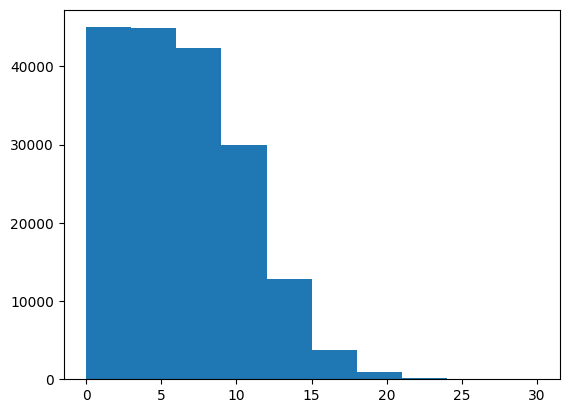

In [ ]:
# creating positional embeddings

# finding the distribution of line_number
plt.hist(train_df["line_number"], bins= 10);

In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [ ]:
# one hot encoding using tensor flow to enode "line_number"
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)

train_line_number_one_hot[:15] , train_line_number_one_hot.shape

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

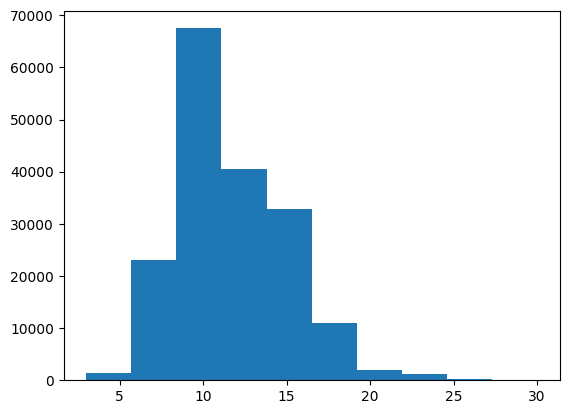

In [ ]:
# Doing the same for the total_lines

# finding the distribution of total_lines
plt.hist(train_df["total_lines"], bins= 10);

In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [ ]:
# finding the 98 % of data total_lines
np.percentile(train_df["total_lines"],98)

20.0

In [ ]:
# one hot encoding total_lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)

train_total_lines_one_hot.shape , train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Model 5 : Tribird model steps:

steps :
1. creating a token-level model
2. creating a char-level model
3. Creating a model for `line_number` feature
4. Creating a model for `total_lines` feature
5. combining outputs of 1 & 2 using tf.keras.layers.Concatenate
6. combining the outputs of 3 & 4 & 5 using tf.keras.layers.Concatenate
7. creating output layer to accept the tribried embedding and output model probabilites
5. combining the inputs of 1, 2 ,3 ,4 and outputs of 7 into a tf.keras.Model

In [ ]:
#1 token-level model
token_inputs = layers.Input(shape=[], dtype = tf.string, name = "token_inputs")
token_embeddings = USE(token_inputs)
token_outputs = layers.Dense(128 , activation = "relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2 Char-level model
char_inputs = layers.Input(shape =(1,), dtype = tf.string , name= "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

#3 Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype= tf.float32, name="line_number_input")
line_number_outputs = layers.Dense(32, activation= "relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,line_number_outputs)

#4 Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype= tf.float32, name="total_lines_input")
total_lines_outputs = layers.Dense(32, activation= "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,total_lines_outputs)

#5 combining 1 & 2 using Concatenate ["hybrid embedding"]
combined_embeddings = layers.Concatenate(name= "char_token_hybrid_embeddings")([token_model.output, char_model.output])
x = layers.Dense(256, activation="relu")(combined_embeddings)
x= layers.Dropout(0.5)(x)

#6 combining 3, 4, 5 using Concatenate ["Tribird embedding"]
tribrid_embedding = layers.Concatenate(name= "char_token_positional_embeddings")([line_number_model.output ,
                                                                                 total_lines_model.output,
                                                                                 x])
#7 creating output layer
output_layer = layers.Dense(5, activation="softmax", name= "output_layer")(tribrid_embedding)

#8 putting all togther into a model
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                         total_lines_model.input,
                                         token_model.input,
                                         char_model.input] ,
                        outputs = output_layer,
                        name= "tribrid_embeddings_model")


In [ ]:
# getting a model summary
model_5.summary()

Model: "tribrid_embeddings_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token

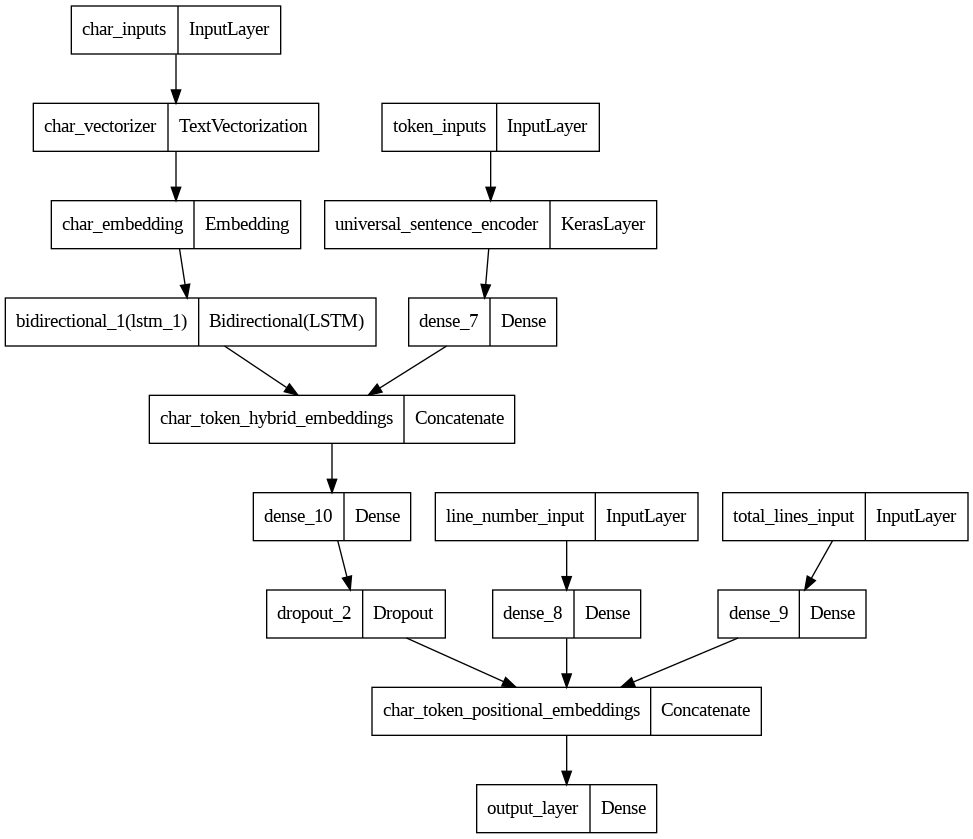

In [ ]:
plot_model(model_5)

In [ ]:
# combiling the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# creating optimized dataset for tribrid embedding model in this order line_number =>total_lines => tokens => chars
train_tribird_dataset = pretefch_dataset((train_line_number_one_hot,
                                          train_total_lines_one_hot,
                                          train_sentences,
                                          train_chars), train_labels_one_hot)

val_tribrid_dataset = pretefch_dataset((val_line_number_one_hot,
                                                          val_total_lines_one_hot,
                                                          val_sentences,
                                                          val_chars),val_labels_one_hot )

In [ ]:
# checking iputs shape
train_tribird_dataset, val_tribrid_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# fitting the model
model_5_history = model_5.fit(train_tribird_dataset,
                              steps_per_epoch = int(0.1*len(train_tribird_dataset)),
                              epochs = 3,
                              validation_data = val_tribrid_dataset,
                              validation_steps =int(0.1*len(val_tribrid_dataset)) )

Epoch 1/3
562/562 [==============================] - 38s 51ms/step - loss: 1.0936 - accuracy: 0.7281 - val_loss: 0.9806 - val_accuracy: 0.8042
Epoch 2/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9668 - accuracy: 0.8168 - val_loss: 0.9485 - val_accuracy: 0.8278
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.9492 - accuracy: 0.8236 - val_loss: 0.9399 - val_accuracy: 0.8341


In [ ]:
# evaluating the model in the vlidation dataset
model_5.evaluate(val_tribrid_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.9380 - accuracy: 0.8329


[0.9380101561546326, 0.8329140543937683]

In [ ]:
# making predictions with the model
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_pred_probs

945/945 [==============================] - 21s 19ms/step


array([[0.5104073 , 0.12509377, 0.00949499, 0.33758947, 0.01741443],
       [0.56026435, 0.09413348, 0.03893718, 0.29676723, 0.00989779],
       [0.27855226, 0.10969663, 0.1000495 , 0.44432202, 0.06737959],
       ...,
       [0.03144086, 0.10351472, 0.03935818, 0.03025482, 0.79543144],
       [0.0280961 , 0.27885315, 0.07933445, 0.02811203, 0.58560425],
       [0.18802768, 0.5702669 , 0.12458864, 0.05076071, 0.06635608]],
      dtype=float32)

In [ ]:
# converting the preb probs into preds
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# calculating model results
model_5_results= calculate_results(y_true= val_labels_encoded, y_pred=model_5_preds)
model_5_results

{'accuracy': 83.29140738779293,
 'precision': 0.8320152677420782,
 'recall': 0.8329140738779293,
 'f1': 0.8320822521301536}

## TO-DO
* model 6 : add positional embeddings to model 1
* model 7: replace pretrained embeddings in model 5 with custom token embeddings in model 1


### Model 6 : conv1D with custom token embeddings + positional embeddings
steps :
1. creating a token-level model
2. Creating a model for `line_number` feature
3. Creating a model for `total_lines` feature
4. combining the outputs of 1 & 2 & 3  using tf.keras.layers.Concatenate
5. creating output layer to accept the hybird embedding and output model probabilites
6. combining the inputs of 1, 2 ,3 and outputs of 5 into a tf.keras.Model


In [ ]:
#1 Conv 1D model
token_inputs = layers.Input(shape=(1,), dtype = tf.string, name ="token_input")
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
x= layers.Conv1D(64,kernel_size=5, padding="same", activation="relu")(token_embeddings)
token_outputs= layers.GlobalAveragePooling1D()(x)
token_model= tf.keras.Model(inputs= token_inputs , outputs =token_outputs)

#2 line number model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name= "line_number_input")
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model= tf.keras.Model(inputs= line_number_inputs, outputs= line_number_outputs)

#3 total_lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_line_input")
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs= total_lines_inputs, outputs= total_lines_outputs)

#4 combining 1 & 2 & 3 in this order line_number => total_lines => token
combined_token_pos = tf.keras.layers.Concatenate(name="token_positional_embeddings")([line_number_model.output,
                                                                                      total_lines_model.output,
                                                                                      token_model.output])
#5 output layer of the hybrid embeddings
output_layer = layers.Dense(5, activation="softmax")(combined_token_pos)

#6 combining the inputs and outputs into a Model
model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input],
                         outputs = output_layer,
                         name= "hibrid_token_positional_embeddings_model")


In [ ]:
# model summary
model_6.summary()

Model: "hibrid_token_positional_embeddings_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['token_input[0][0]']         
 ctorization)                                                                                     
                                                                                                  
 token_embedding (Embedding  (None, 55, 128)              8299648   ['text_vectorization[1][0]']  
 )                                                                                                
                                                           

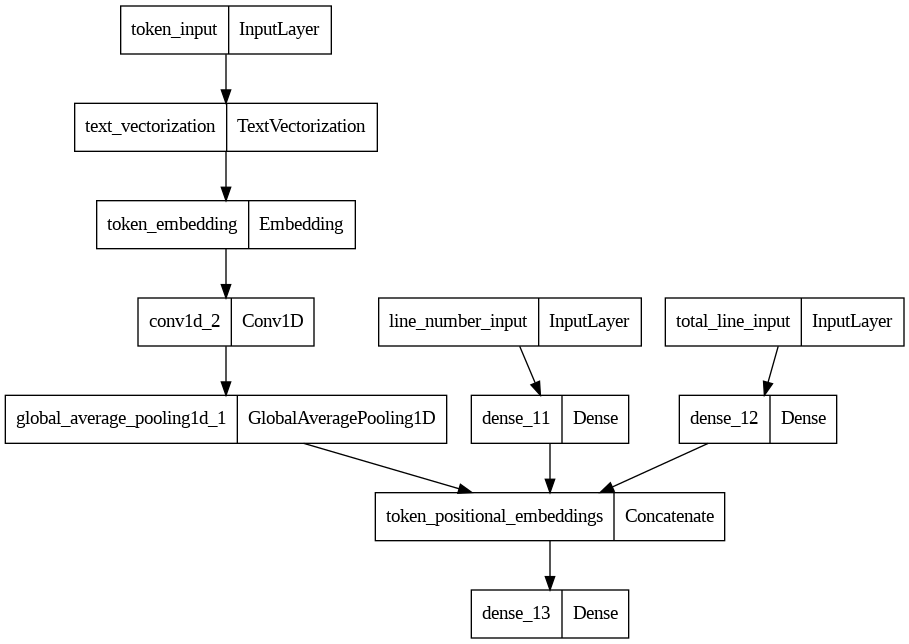

In [ ]:
plot_model(model_6)

In [ ]:
# compiling the model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
## preparing the prefetched and batched dataset for the training dataset in the same order on inputs as model
## line_number => total_lines => token
train_token_pos_dataset = pretefch_dataset((train_line_number_one_hot,
                                            train_total_lines_one_hot,
                                            train_sentences),train_labels_one_hot)
val_token_pos_dataset = pretefch_dataset((val_line_number_one_hot,
                                          val_total_lines_one_hot,
                                          val_sentences), val_labels_one_hot)

In [ ]:
# fitting the model
model_6_history= model_6.fit(train_token_pos_dataset,
            epochs=3,
            steps_per_epoch = int(0.1*len(train_token_pos_dataset)),
            validation_data =val_token_pos_dataset,
            validation_steps = int(0.1*len(val_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 19s 31ms/step - loss: 1.0287 - accuracy: 0.7931 - val_loss: 0.9719 - val_accuracy: 0.8275
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.9243 - accuracy: 0.8641 - val_loss: 0.9556 - val_accuracy: 0.8364
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.9110 - accuracy: 0.8692 - val_loss: 0.9462 - val_accuracy: 0.8441


In [ ]:
# evaluate on the validation dataset
model_6.evaluate(val_token_pos_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.9395 - accuracy: 0.8445


[0.9395247101783752, 0.8444657921791077]

In [ ]:
# make predections
model_6_pred_probs = model_6.predict(val_token_pos_dataset)
model_6_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.48541057, 0.05956331, 0.06179195, 0.33696684, 0.05626733],
       [0.35728738, 0.08398601, 0.13424203, 0.37213093, 0.05235362],
       [0.14085759, 0.05485594, 0.07852567, 0.7137428 , 0.01201802],
       ...,
       [0.01731956, 0.03313135, 0.01542798, 0.01920651, 0.9149146 ],
       [0.04477482, 0.6276297 , 0.05907815, 0.03877227, 0.22974513],
       [0.20078127, 0.649855  , 0.07075693, 0.03717242, 0.04143434]],
      dtype=float32)

In [ ]:
# getting the model preds
model_6_preds = tf.argmax(model_6_pred_probs,axis=1)
model_6_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 3, 3, ..., 4, 1, 1])>

In [ ]:
# getting the model results
model_6_results = calculate_results(y_true=val_labels_encoded, y_pred=model_6_preds)
model_6_results

{'accuracy': 84.44657751886668,
 'precision': 0.8414156096035941,
 'recall': 0.8444657751886667,
 'f1': 0.8423251104553557}

### model 7: replace pretrained embeddings in model 5 with custom token embeddings in model 1

In [ ]:
#1 token-level model
token_inputs = layers.Input(shape=(1,), dtype = tf.string, name ="token_input")
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
token_flatten = layers.Flatten()(token_embeddings)
token_outputs = layers.Dense(128, activation="relu")(token_flatten)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2 Char-level model
char_inputs = layers.Input(shape =(1,), dtype = tf.string , name= "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_dense = layers.Dense(128, activation="relu")(char_bi_lstm)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_dense)


#3 Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype= tf.float32, name="line_number_input")
line_number_outputs = layers.Dense(32, activation= "relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,line_number_outputs)

#4 Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype= tf.float32, name="total_lines_input")
total_lines_outputs = layers.Dense(32, activation= "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,total_lines_outputs)

#5 combining 1 & 2 using Concatenate ["hybrid embedding"]
combined_embeddings = layers.Concatenate(name= "char_token_hybrid_embeddings")([token_model.output, char_model.output])
x = layers.Dense(256, activation="relu")(combined_embeddings)
x= layers.Dropout(0.5)(x)

#6 combining 3, 4, 5 using Concatenate ["Tribird embedding"]
tribrid_embedding = layers.Concatenate(name= "char_token_positional_embeddings")([line_number_model.output ,
                                                                                 total_lines_model.output,
                                                                                 x])
#7 creating output layer
output_layer = layers.Dense(5, activation="softmax", name= "output_layer")(tribrid_embedding)

#8 putting all togther into a model
model_7 = tf.keras.Model(inputs = [line_number_model.input,
                                         total_lines_model.input,
                                         token_model.input,
                                         char_model.input] ,
                        outputs = output_layer,
                        name= "tribrid_custom_token_embeddings_model")


In [ ]:
# getting a model summary
model_7.summary()

Model: "tribrid_custom_token_embeddings_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['token_input[0][0]']         
 ctorization)                                                                                     
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0   

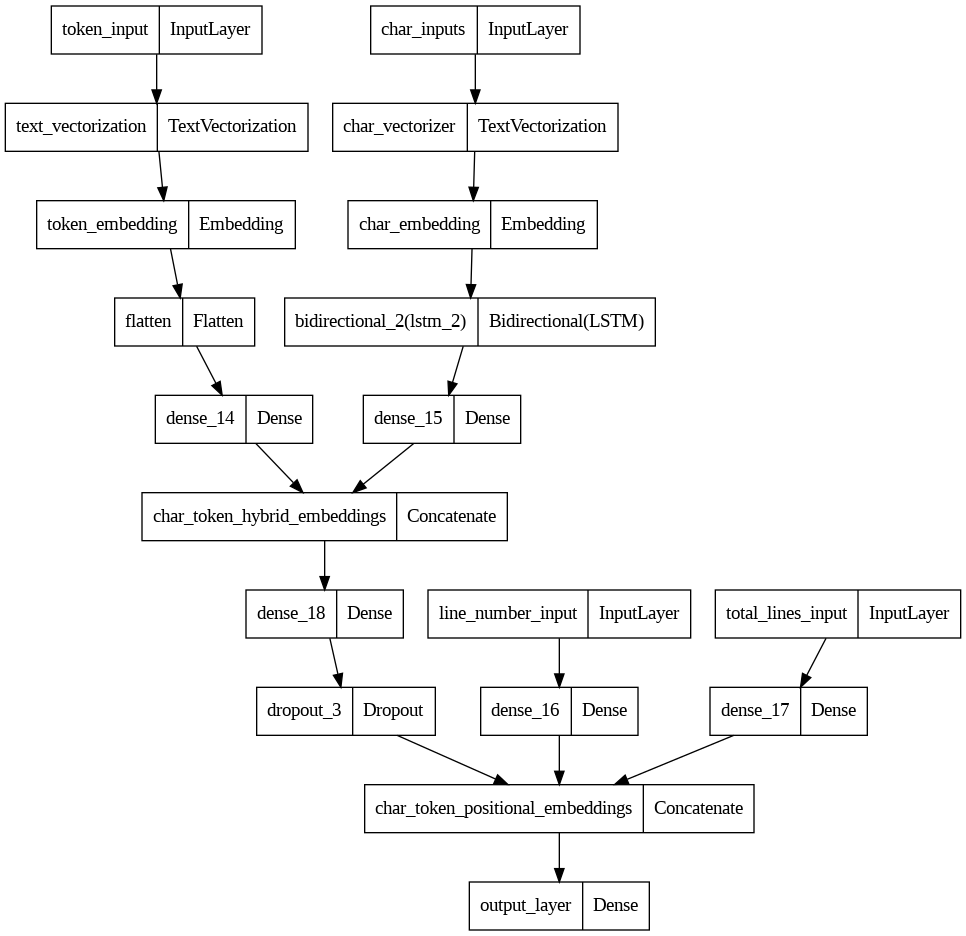

In [ ]:
plot_model(model_7)

In [ ]:
# combiling the model
model_7.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# fitting the model
model_7_history = model_7.fit(train_tribird_dataset,
                              steps_per_epoch = int(0.1*len(train_tribird_dataset)),
                              epochs = 3,
                              validation_data = val_tribrid_dataset,
                              validation_steps =int(0.1*len(val_tribrid_dataset)) )

Epoch 1/3
562/562 [==============================] - 47s 66ms/step - loss: 0.9560 - accuracy: 0.8323 - val_loss: 0.9311 - val_accuracy: 0.8331
Epoch 2/3
562/562 [==============================] - 24s 43ms/step - loss: 0.8599 - accuracy: 0.8926 - val_loss: 0.9245 - val_accuracy: 0.8321
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.8447 - accuracy: 0.9032 - val_loss: 0.9283 - val_accuracy: 0.8275


In [ ]:
# evaluating the model in the vlidation dataset
model_7.evaluate(val_tribrid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.9210 - accuracy: 0.8308


[0.9209803342819214, 0.8307626247406006]

In [ ]:
# making predictions with the model
model_7_pred_probs = model_7.predict(val_tribrid_dataset)
model_7_pred_probs

945/945 [==============================] - 14s 12ms/step


array([[0.5671062 , 0.03417682, 0.08931788, 0.25840172, 0.05099742],
       [0.2602767 , 0.1168556 , 0.11287862, 0.46553922, 0.04444979],
       [0.0753876 , 0.0515992 , 0.03091254, 0.80904114, 0.03305946],
       ...,
       [0.03171014, 0.04745831, 0.01802473, 0.03365021, 0.86915666],
       [0.03532424, 0.7792027 , 0.03327323, 0.04574047, 0.10645939],
       [0.04832891, 0.8502848 , 0.04203596, 0.03376991, 0.02558035]],
      dtype=float32)

In [ ]:
# converting the preb probs into preds
model_7_preds = tf.argmax(model_7_pred_probs,axis=1)
model_7_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 3, 3, ..., 4, 1, 1])>

In [ ]:
# calculating model results
model_7_results= calculate_results(y_true= val_labels_encoded, y_pred=model_7_preds)
model_7_results

{'accuracy': 83.07626108830928,
 'precision': 0.8314401606157832,
 'recall': 0.8307626108830928,
 'f1': 0.8297527338213706}

## Comparing expriments results

In [ ]:
all_expriments_results = pd.DataFrame({"model_0_baseline":baseline_results,
                                       "model_1_custom_token_embedding":model_1_results,
                                       "model_2_pretrained_token_embedding":model_2_results,
                                       "model_3_custom_char_embedding":model_3_results,
                                       "model_4_hybrid_char_token_embedding":model_4_results,
                                       "model_5_tribrid_char_token_pos_embedding":model_5_results,
                                       "model_6_hybrid_token_pos_embeddings":model_6_results,
                                       "model_7_tribird_char_custom_token_pos_embedding":model_7_results})
all_expriments_results = all_expriments_results.transpose()


In [ ]:
# change accuracy scale to e simillar to the rest of metrics
all_expriments_results["accuracy"] = all_expriments_results["accuracy"]/100

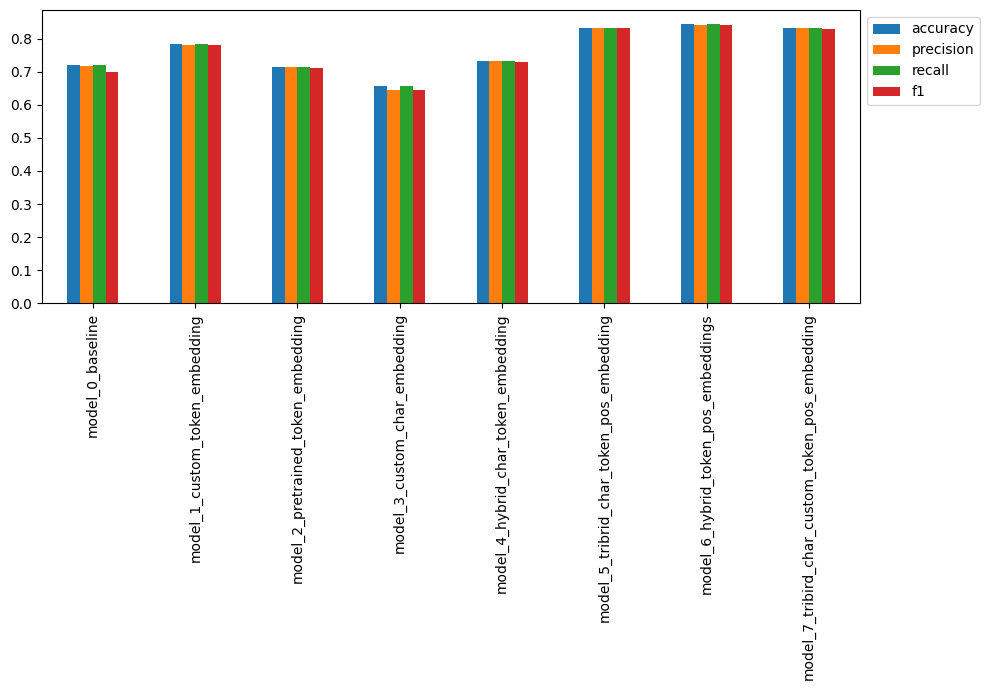

In [ ]:
# plotting
fig, ax = plt.subplots(figsize=(10, 7))
all_expriments_results.plot(kind="bar", ax=ax)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

<Axes: >

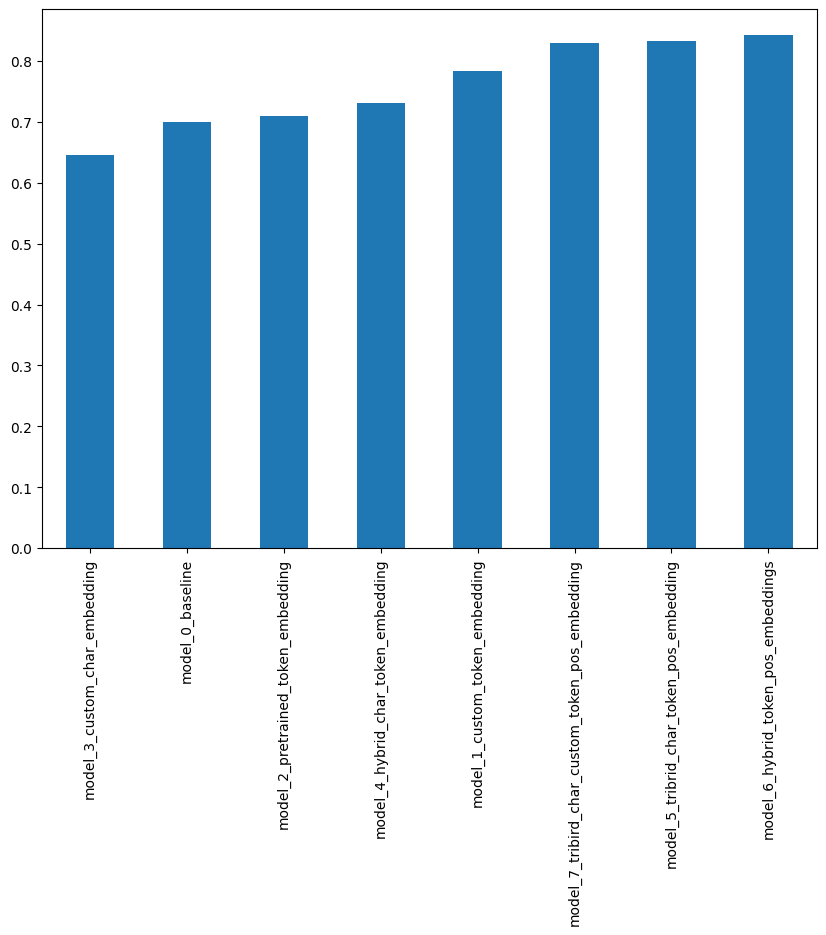

In [ ]:
# sorting models by f1 score
all_expriments_results.sort_values("f1",ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

In [ ]:
all_expriments_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.784986,0.781583,0.784986,0.782343
model_2_pretrained_token_embedding,0.712862,0.713453,0.712862,0.710007
model_3_custom_char_embedding,0.656229,0.645458,0.656229,0.644732
model_4_hybrid_char_token_embedding,0.732524,0.732695,0.732524,0.730502
model_5_tribrid_char_token_pos_embedding,0.832914,0.832015,0.832914,0.832082
model_6_hybrid_token_pos_embeddings,0.844466,0.841416,0.844466,0.842325
model_7_tribird_char_custom_token_pos_embedding,0.830763,0.831440,0.830763,0.829753


## Evaluate the best model `Model 5` on test dataset

In [ ]:
## getting the dataset ready for the model
##dataset in this order  line_number => total_lines  => sentences => chars
test_pos_token_char_dataset = pretefch_dataset((test_line_number_one_hot,test_total_lines_one_hot,test_sentences,test_chars),test_labels_one_hot)

test_pos_token_char_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Making predictions with test dataset
test_pred_probs = model_5.predict(test_pos_token_char_dataset)

test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:15]

942/942 [==============================] - 19s 20ms/step


<tf.Tensor: shape=(15,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 1, 0, 3, 2, 2, 2, 4])>

In [ ]:
# Evaluating test predictions
test_results = calculate_results(y_true = test_labels_encoded, y_pred=test_preds)
test_results

{'accuracy': 82.90691886510702,
 'precision': 0.8281079839653793,
 'recall': 0.8290691886510702,
 'f1': 0.8280723104617372}

## Doing more experiments to get a better results

the expriments to be tried:

1. Tribird model with Bert pubmed [`old feature`]
2. Bert pubmed token embeddings [`same as model 1 but with bert embeddings`]
3. Tribrid Bert pubmed [`new feature`]
4. Hybrid Bert pubmed [`new feature`]
5. Hybrid Bert pubmed [`old feature`]


### Expriment 1 : exp_model_1 Tribird model with Bert pubmed [old feature]

In [ ]:
!pip install  tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.1 MB/s eta 0:00:00


In [ ]:
import tensorflow_text as text
import tensorflow_hub as hub

#loading bert pubmed & preprocessor from the hub
bert_pubmed = hub.load('https://tfhub.dev/google/experts/bert/pubmed/2')
bert_preprocessor = hub.load('https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3') # simillar as tokenization but to change raw text into a numeric represenation that bert models could deal with.

# injecting bert pubmed  & preprocessor as keras layers
bert_pubmed_layer = hub.KerasLayer(bert_pubmed, name="bert_pubmed")
bert_preprocessor_layer = hub.KerasLayer(bert_preprocessor,name="bert_preprocrss")

In [ ]:
# Model
#1 token-level model [with bert preprocessor and bert pubmed]
token_inputs = layers.Input(shape=[], dtype = tf.string, name = "token_inputs")
bert_tokens = bert_preprocessor_layer(token_inputs)
bert_embeddings = bert_pubmed_layer(bert_tokens, training=False)
pooled_output =bert_embeddings['pooled_output'] # Fixed-length vector representing entire input sequence
token_outputs = layers.Dense(128 , activation = "relu")(pooled_output)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2 Char-level model
char_inputs = layers.Input(shape =(1,), dtype = tf.string , name= "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

#3 Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype= tf.float32, name="line_number_input")
line_number_outputs = layers.Dense(32, activation= "relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,line_number_outputs)

#4 Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype= tf.float32, name="total_lines_input")
total_lines_outputs = layers.Dense(32, activation= "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,total_lines_outputs)

#5 combining 1 & 2 using Concatenate ["hybrid embedding"]
combined_embeddings = layers.Concatenate(name= "char_token_hybrid_embeddings")([token_model.output, char_model.output])
x = layers.Dense(256, activation="relu")(combined_embeddings)
x= layers.Dropout(0.5)(x)

#6 combining 3, 4, 5 using Concatenate ["Tribird embedding"]
tribrid_embedding = layers.Concatenate(name= "char_token_positional_embeddings")([line_number_model.output ,
                                                                                 total_lines_model.output,
                                                                                 x])
#7 creating output layer
output_layer = layers.Dense(5, activation="softmax", name= "output_layer")(tribrid_embedding)

#8 putting all togther into a model
exp_model_1 = tf.keras.Model(inputs = [line_number_model.input,
                                         total_lines_model.input,
                                         token_model.input,
                                         char_model.input] ,
                        outputs = output_layer,
                        name= "bert_tribrid_model")


In [ ]:
# compiling and fitting the model
exp_model_1.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                     optimizer= tf.keras.optimizers.Adam() ,
                     metrics = ['accuracy'])
exp_model_1_history = exp_model_1.fit(train_tribird_dataset,
                                      steps_per_epoch = int(0.1*len(train_tribird_dataset)),
                                      validation_data = val_tribrid_dataset,
                                      epochs=3,
                                      validation_steps = int(0.1*len(val_tribrid_dataset)),
                                      callbacks = [create_tensorboard_callback("tensorboard","bert_tribrid_model")])



Got `type(handle)`: <class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>


Saving TensorBoard log files to: tensorboard/bert_tribrid_model/20240126-181718
Epoch 1/3
562/562 [==============================] - 270s 421ms/step - loss: 0.5550 - accuracy: 0.8052 - val_loss: 0.3794 - val_accuracy: 0.8610
Epoch 2/3
562/562 [==============================] - 241s 429ms/step - loss: 0.3904 - accuracy: 0.8597 - val_loss: 0.3522 - val_accuracy: 0.8584
Epoch 3/3
562/562 [==============================] - 245s 437ms/step - loss: 0.3590 - accuracy: 0.8679 - val_loss: 0.3190 - val_accuracy: 0.8830


In [ ]:
# evaluate the model
exp_model_1.evaluate(val_tribrid_dataset)

945/945 [==============================] - 324s 343ms/step - loss: 0.3192 - accuracy: 0.8824


[0.3192155659198761, 0.8824308514595032]

In [ ]:
# making predections
exp_model_1_pred_probs = exp_model_1.predict(val_tribrid_dataset)

exp_model_1_preds = tf.argmax(exp_model_1_pred_probs, axis=1)
exp_model_1_preds

945/945 [==============================] - 320s 335ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 0, 3, ..., 4, 1, 1])>

In [ ]:
# getting the model results
exp_model_1_results = calculate_results(y_true= val_labels_encoded, y_pred=exp_model_1_preds)
exp_model_1_results

{'accuracy': 88.24308221898583,
 'precision': 0.8820215993851195,
 'recall': 0.8824308221898584,
 'f1': 0.8813816015554649}

 ### Expriment 2 : exp_model_2 Bert pubmed token embeddings

In [ ]:
token_inputs = layers.Input(shape=[], dtype = tf.string, name = "token_inputs")
bert_tokens = bert_preprocessor_layer(token_inputs)
bert_embeddings = bert_pubmed_layer(bert_tokens,training=False)
pooled_output = bert_embeddings["pooled_output"]
x = layers.Dense(128, activation="relu")(pooled_output)
token_outputs = layers.Dense(5, activation="softmax")(x)

exp_model_2 = tf.keras.Model(inputs= token_inputs,
                             outputs=token_outputs ,
                             name="bert_token_model")

#compiling the model
exp_model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
#fitting the model
exp_model_2_results = exp_model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 222s 391ms/step - loss: 0.5433 - accuracy: 0.8087 - val_loss: 0.4391 - val_accuracy: 0.8447
Epoch 2/3
562/562 [==============================] - 228s 407ms/step - loss: 0.4506 - accuracy: 0.8396 - val_loss: 0.4415 - val_accuracy: 0.8255
Epoch 3/3
562/562 [==============================] - 228s 405ms/step - loss: 0.4348 - accuracy: 0.8418 - val_loss: 0.4119 - val_accuracy: 0.8517


In [ ]:
# evaluate the model
exp_model_2.evaluate(valid_dataset)

945/945 [==============================] - 314s 332ms/step - loss: 0.4081 - accuracy: 0.8545


[0.4080968201160431, 0.8544617891311646]

In [ ]:
# making predections
exp_model_2_pred_probs = exp_model_2.predict(valid_dataset)

exp_model_2_preds = tf.argmax(exp_model_2_pred_probs, axis=1)
exp_model_2_preds

945/945 [==============================] - 313s 331ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 1, 1])>

In [ ]:
# getting the model results
exp_model_2_results = calculate_results(y_true= val_labels_encoded, y_pred=exp_model_2_preds)
exp_model_2_results

{'accuracy': 85.44618032569839,
 'precision': 0.8553723420577725,
 'recall': 0.854461803256984,
 'f1': 0.8541559419925087}

### New feature : line number of total features
eg: 0_of_11 1_of_11 ...etc

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df['line_number_of_total_lines'] = train_df['line_number'].astype(str) + '_of_' + train_df['total_lines'].astype(str)
val_df['line_number_of_total_lines'] = val_df['line_number'].astype(str) + '_of_' + val_df['total_lines'].astype(str)
train_df

,target,text,line_number,total_lines,line_number_of_total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,0_of_11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,1_of_11
2,METHODS,outcome measures included pain reduction and i...,2,11,2_of_11
3,METHODS,pain was assessed using the visual analog pain...,3,11,3_of_11
4,METHODS,secondary outcome measures included the wester...,4,11,4_of_11
...,...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11,7_of_11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11,8_of_11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11,9_of_11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11,10_of_11


In [ ]:
# val_df = val_df[val_df['total_lines'] != 26]

In [ ]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [ ]:
val_df['total_lines'].value_counts()

11    4284
10    3751
12    3744
9     3330
13    3066
14    2565
8     1935
15    1920
16    1547
7     1096
17     666
6      539
18     475
19     460
20     189
21     176
5      162
24      75
22      69
26      54
25      52
4       45
3       12
Name: total_lines, dtype: int64

In [ ]:
# Creating an instance
one_hot_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')

train_line_number_of_total_lines_encoded  = one_hot_encoder.fit_transform(train_df["line_number_of_total_lines"].to_numpy().reshape(-1, 1)).astype("float32") # expand the dims then turn it into float32
val_line_number_of_total_lines_encoded  = one_hot_encoder.transform(val_df["line_number_of_total_lines"].to_numpy().reshape(-1, 1)).astype("float32")

train_line_number_of_total_lines_encoded.shape, val_line_number_of_total_lines_encoded.shape



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((180040, 460), (30212, 460))



 ### Expriment 3 : exp_model_3 Tribrid Bert pubmed [`new feature`]


In [ ]:
# Model
#1 token-level model [with bert preprocessor and bert pubmed]
token_inputs = layers.Input(shape=[], dtype = tf.string, name = "token_inputs")
bert_tokens = bert_preprocessor_layer(token_inputs)
bert_embeddings = bert_pubmed_layer(bert_tokens, training=False)
pooled_output =bert_embeddings['pooled_output'] # Fixed-length vector representing entire input sequence
token_outputs = layers.Dense(128 , activation = "relu")(pooled_output)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2 Char-level model
char_inputs = layers.Input(shape =(1,), dtype = tf.string , name= "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

#3 New feature model
line_number_of_total_lines_inputs = layers.Input(shape=(460,), dtype= tf.float32, name="line_number_of_total_lines")
line_number_of_total_lines_outputs = layers.Dense(32, activation= "relu")(line_number_of_total_lines_inputs)
line_number_of_total_lines_model = tf.keras.Model(line_number_of_total_lines_inputs,
                                                  line_number_of_total_lines_outputs)

#4 Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype= tf.float32, name="total_lines_input")
total_lines_outputs = layers.Dense(32, activation= "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,total_lines_outputs)

#5 combining 1 & 2 using Concatenate ["hybrid embedding"]
combined_embeddings = layers.Concatenate(name= "char_token_hybrid_embeddings")([token_model.output, char_model.output])
x = layers.Dense(256, activation="relu")(combined_embeddings)
x= layers.Dropout(0.5)(x)

#6 combining 3, 4, 5 using Concatenate ["Tribird embedding"]
tribrid_embedding = layers.Concatenate(name= "char_token_positional_embeddings")([line_number_of_total_lines_model.output ,
                                                                                 total_lines_model.output,
                                                                                 x])
#7 creating output layer
output_layer = layers.Dense(5, activation="softmax", name= "output_layer")(tribrid_embedding)

#8 putting all togther into a model
exp_model_3 = tf.keras.Model(inputs = [line_number_of_total_lines_model.input,
                                         total_lines_model.input,
                                         token_model.input,
                                         char_model.input] ,
                        outputs = output_layer,
                        name= "bert_tribrid_model_new_feature")
#compiling the model
exp_model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
print(val_line_number_of_total_lines_encoded.shape)
print(val_total_lines_one_hot.shape)
print(np.array(val_sentences).shape)
print(np.array(val_chars).shape)
print(np.array(val_labels_one_hot).shape)


(30212, 460)
(30212, 20)
(30212,)
(30212,)
(30212, 5)


In [ ]:
# making prefetched & batched datasets in this order line_number_of_total_lines ==> total_lines ==> sentences ==>chars
new_feature_tribirid_train_dataset =pretefch_dataset((train_line_number_of_total_lines_encoded,
                                                      train_total_lines_one_hot,
                                                      train_sentences,
                                                      train_chars),train_labels_one_hot)

new_feature_tribirid_val_dataset =pretefch_dataset((val_line_number_of_total_lines_encoded,
                                                      val_total_lines_one_hot,
                                                      val_sentences,
                                                      val_chars),val_labels_one_hot)
new_feature_tribirid_train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 460), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
#fitting the model
exp_model_3_results = exp_model_3.fit(new_feature_tribirid_train_dataset,
                              steps_per_epoch=int(0.1 * len(new_feature_tribirid_train_dataset)),
                              epochs=3,
                              validation_data=new_feature_tribirid_val_dataset,
                              validation_steps=int(0.1 * len(new_feature_tribirid_val_dataset)))

Epoch 1/3
562/562 [==============================] - 259s 434ms/step - loss: 0.5673 - accuracy: 0.8019 - val_loss: 0.3977 - val_accuracy: 0.8634
Epoch 2/3
562/562 [==============================] - 244s 434ms/step - loss: 0.3856 - accuracy: 0.8661 - val_loss: 0.3331 - val_accuracy: 0.8723
Epoch 3/3
562/562 [==============================] - 233s 414ms/step - loss: 0.3383 - accuracy: 0.8770 - val_loss: 0.3027 - val_accuracy: 0.8896


In [ ]:
# evaluate the model
exp_model_3.evaluate(new_feature_tribirid_val_dataset)

945/945 [==============================] - 322s 341ms/step - loss: 0.2984 - accuracy: 0.8879


[0.29838451743125916, 0.8878922462463379]

In [ ]:
# making predections
exp_model_3_pred_probs = exp_model_3.predict(new_feature_tribirid_val_dataset)

exp_model_3_preds = tf.argmax(exp_model_3_pred_probs, axis=1)
exp_model_3_preds

945/945 [==============================] - 321s 336ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 0, 3, ..., 4, 1, 1])>

In [ ]:
# getting the model results
exp_model_3_results = calculate_results(y_true= val_labels_encoded, y_pred=exp_model_3_preds)
exp_model_3_results

{'accuracy': 88.7892228253674,
 'precision': 0.8876390430055767,
 'recall': 0.8878922282536741,
 'f1': 0.8874691322890348}

 ### Expriment 4 : exp_model_4 Hybrid Bert pubmed [new feature]


In [ ]:
#1 token-level model [with bert preprocessor and bert pubmed]
token_inputs = layers.Input(shape=[], dtype = tf.string, name = "token_inputs")
bert_tokens = bert_preprocessor_layer(token_inputs)
bert_embeddings = bert_pubmed_layer(bert_tokens, training=False)
pooled_output =bert_embeddings['pooled_output'] # Fixed-length vector representing entire input sequence
token_outputs = layers.Dense(128 , activation = "relu")(pooled_output)
token_model = tf.keras.Model(token_inputs, token_outputs)


#2 New feature model
line_number_of_total_lines_inputs = layers.Input(shape=(460,), dtype= tf.float32, name="line_number_of_total_lines")
line_number_of_total_lines_outputs = layers.Dense(32, activation= "relu")(line_number_of_total_lines_inputs)
line_number_of_total_lines_model = tf.keras.Model(line_number_of_total_lines_inputs,
                                                  line_number_of_total_lines_outputs)

# 3. concatinating token and char inputs [hybrid token emedding]
token_pos_concat = layers.Concatenate(name="token_pos_hybrid")([token_model.output,
                                                                line_number_of_total_lines_model.output])

# 4.creating output layers - adding in dropout discussed in section 4.2 of the paper
combined_dropout = layers.Dropout(0.5)(token_pos_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. construct model with char and token inputs
exp_model_4= tf.keras.Model(inputs = [line_number_of_total_lines_model.input,token_model.input],
                        outputs= output_layer,
                        name="bert_hybrid_new_feature")

#compiling the model
exp_model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# creating a datasets in this order line_number_of_total_lines ==> sentences
new_feature_hybirid_train_dataset = pretefch_dataset((train_line_number_of_total_lines_encoded,
                                                      train_sentences), train_labels_one_hot)

new_feature_hybirid_val_dataset = pretefch_dataset((val_line_number_of_total_lines_encoded,
                                                      val_sentences), val_labels_one_hot)

new_feature_hybirid_train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 460), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
#fitting the model
exp_model_4_results = exp_model_4.fit(new_feature_hybirid_train_dataset,
                              steps_per_epoch=int(0.1 * len(new_feature_hybirid_train_dataset)),
                              epochs=3,
                              validation_data=new_feature_hybirid_val_dataset,
                              validation_steps=int(0.1 * len(new_feature_hybirid_val_dataset)))

Epoch 1/3
562/562 [==============================] - 223s 390ms/step - loss: 0.7564 - accuracy: 0.7284 - val_loss: 0.4381 - val_accuracy: 0.8564
Epoch 2/3
562/562 [==============================] - 219s 390ms/step - loss: 0.5048 - accuracy: 0.8235 - val_loss: 0.3532 - val_accuracy: 0.8747
Epoch 3/3
562/562 [==============================] - 219s 390ms/step - loss: 0.4496 - accuracy: 0.8376 - val_loss: 0.3272 - val_accuracy: 0.8866


In [ ]:
# evaluate the model
exp_model_4.evaluate(new_feature_hybirid_val_dataset)

945/945 [==============================] - 312s 330ms/step - loss: 0.3132 - accuracy: 0.8880


[0.31316208839416504, 0.888024628162384]

In [ ]:
# making predections
exp_model_4_pred_probs = exp_model_4.predict(new_feature_hybirid_val_dataset)

exp_model_4_preds = tf.argmax(exp_model_4_pred_probs, axis=1)
exp_model_4_preds

945/945 [==============================] - 311s 329ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# getting the model results
exp_model_4_results = calculate_results(y_true= val_labels_encoded, y_pred=exp_model_4_preds)
exp_model_4_results

{'accuracy': 88.80246259764331,
 'precision': 0.8885895088242082,
 'recall': 0.8880246259764332,
 'f1': 0.8877231256788323}

 ### Expriment 5 : exp_model_5 Hybrid Bert pubmed [old feature]


In [ ]:
#1 token-level model [with bert preprocessor and bert pubmed]
token_inputs = layers.Input(shape=[], dtype = tf.string, name = "token_inputs")
bert_tokens = bert_preprocessor_layer(token_inputs)
bert_embeddings = bert_pubmed_layer(bert_tokens, training=False)
pooled_output =bert_embeddings['pooled_output'] # Fixed-length vector representing entire input sequence
token_outputs = layers.Dense(128 , activation = "relu")(pooled_output)
token_model = tf.keras.Model(token_inputs, token_outputs)


#2 Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype= tf.float32, name="line_number_input")
line_number_outputs = layers.Dense(32, activation= "relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,line_number_outputs)

#3 Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype= tf.float32, name="total_lines_input")
total_lines_outputs = layers.Dense(32, activation= "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,total_lines_outputs)

# 3. concatinating token and pos inputs [hybrid token emedding]
token_pos_concat = layers.Concatenate(name="token_pos_hybrid")([token_model.output,
                                                                line_number_model.output,
                                                                total_lines_model.output])

# 4.creating output layers
output_layer = layers.Dense(num_classes, activation="softmax")(token_pos_concat)

# 5. construct model with char and token inputs
exp_model_5= tf.keras.Model(inputs = [line_number_model.input,
                                      total_lines_model.input,
                                      token_model.input],
                        outputs= output_layer,
                        name="bert_hybrid_old_feature")

#compiling the model
exp_model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# making prefetched and batced data set in this oreder line_number ==> total_llines ==> sentence
old_feature_hybirid_train_dataset= pretefch_dataset((train_line_number_one_hot,
                                                     train_total_lines_one_hot,
                                                     train_sentences), train_labels_one_hot)

old_feature_hybirid_val_dataset= pretefch_dataset((val_line_number_one_hot,
                                                     val_total_lines_one_hot,
                                                     val_sentences), val_labels_one_hot)
old_feature_hybirid_train_dataset


<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
#fitting the model
exp_model_5_results = exp_model_5.fit(old_feature_hybirid_train_dataset,
                              steps_per_epoch=int(0.1 * len(old_feature_hybirid_train_dataset)),
                              epochs=3,
                              validation_data=old_feature_hybirid_val_dataset,
                              validation_steps=int(0.1 * len(old_feature_hybirid_val_dataset)))

Epoch 1/3
562/562 [==============================] - 232s 409ms/step - loss: 0.5172 - accuracy: 0.8148 - val_loss: 0.3855 - val_accuracy: 0.8664
Epoch 2/3
562/562 [==============================] - 228s 406ms/step - loss: 0.3773 - accuracy: 0.8626 - val_loss: 0.3519 - val_accuracy: 0.8654
Epoch 3/3
562/562 [==============================] - 228s 406ms/step - loss: 0.3477 - accuracy: 0.8710 - val_loss: 0.3213 - val_accuracy: 0.8843


In [ ]:
# evaluate the model
exp_model_5.evaluate(old_feature_hybirid_val_dataset)

945/945 [==============================] - 314s 332ms/step - loss: 0.3209 - accuracy: 0.8788


[0.32087990641593933, 0.8787567615509033]

In [ ]:
# making predections
exp_model_5_pred_probs = exp_model_5.predict(old_feature_hybirid_val_dataset)

exp_model_5_preds = tf.argmax(exp_model_5_pred_probs, axis=1)
exp_model_5_preds

In [ ]:
# getting the model results
exp_model_5_results = calculate_results(y_true= val_labels_encoded, y_pred=exp_model_5_preds)
exp_model_5_results

{'accuracy': 87.87567853832914,
 'precision': 0.8794200692807785,
 'recall': 0.8787567853832914,
 'f1': 0.8789426567706873}

## Comparing the new expriments results

In [ ]:
new_expriments_results = pd.DataFrame({
                                       "exp_model_1_Tribird model with Bert pubmed":exp_model_1_results,
                                       "exp_model_2_Bert pubmed token embeddings":exp_model_2_results,
                                       "exp_model_3_Tribrid Bert pubmed [`new feature`]":exp_model_3_results,
                                       "exp_model_4_Hybrid Bert pubmed [`new feature`]":exp_model_4_results,
                                       "exp_model_5_Hybrid Bert pubmed [`old feature`]":exp_model_5_results,
                                      })
new_expriments_results = new_expriments_results.transpose()


In [ ]:
# change accuracy scale to e simillar to the rest of metrics
new_expriments_results["accuracy"] = new_expriments_results["accuracy"]/100

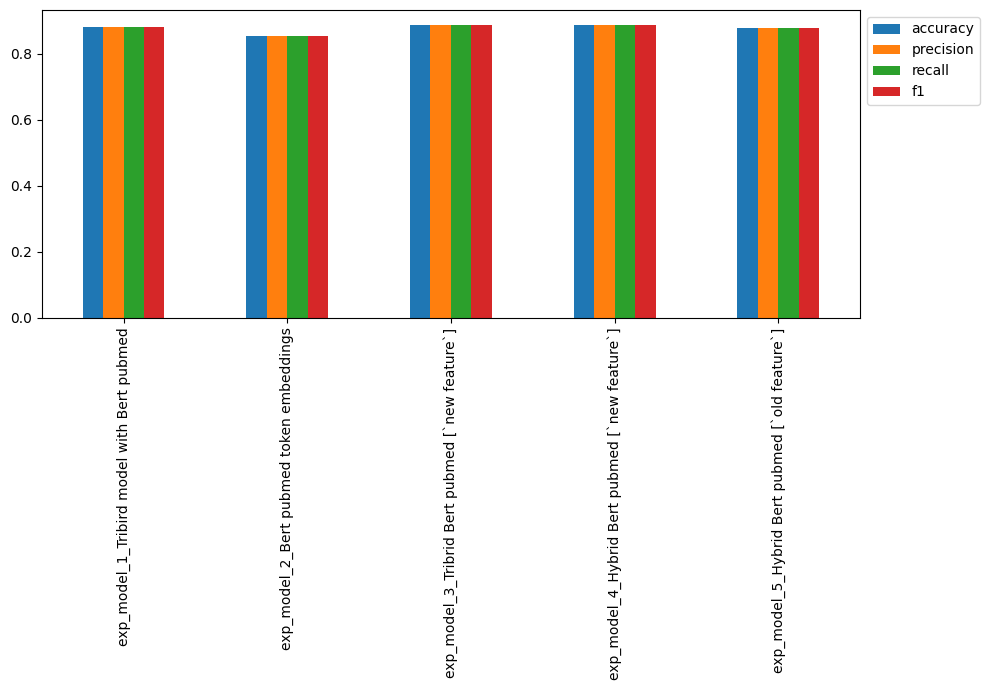

In [ ]:
# plotting
fig, ax = plt.subplots(figsize=(10, 7))
new_expriments_results.plot(kind="bar", ax=ax)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

<Axes: >

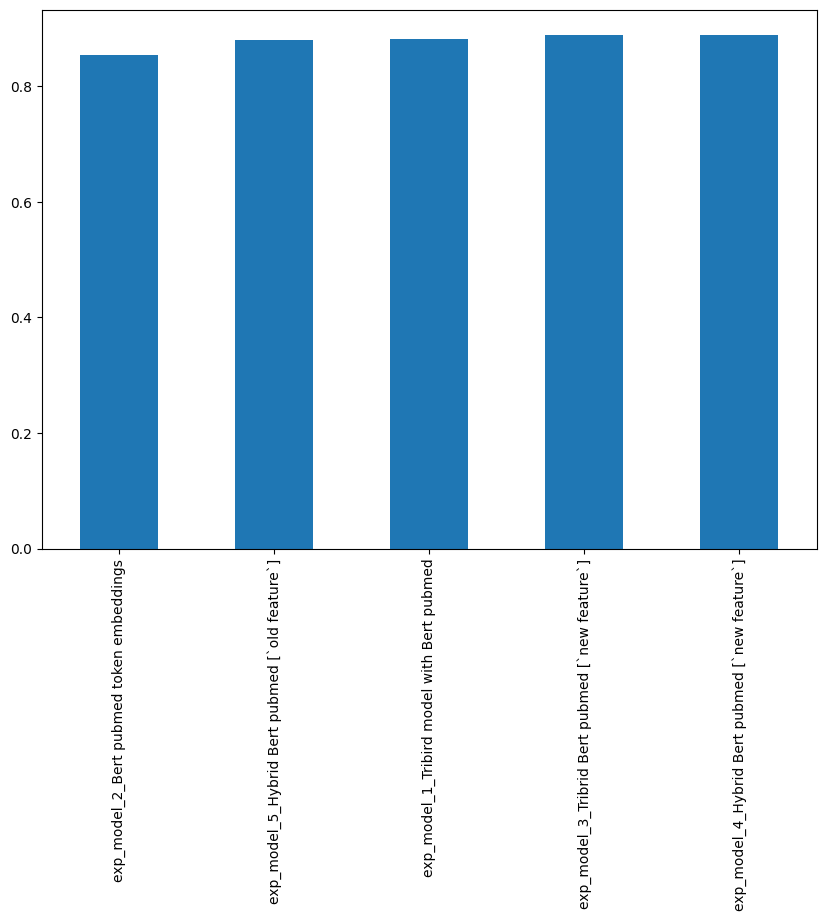

In [ ]:
# sorting models by f1 score
new_expriments_results.sort_values("f1",ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

In [ ]:
new_expriments_results

,accuracy,precision,recall,f1
exp_model_1_Tribird model with Bert pubmed,0.882431,0.882022,0.882431,0.881382
exp_model_2_Bert pubmed token embeddings,0.854462,0.855372,0.854462,0.854156
exp_model_3_Tribrid Bert pubmed [`new feature`],0.887892,0.887639,0.887892,0.887469
exp_model_4_Hybrid Bert pubmed [`new feature`],0.888025,0.888590,0.888025,0.887723
exp_model_5_Hybrid Bert pubmed [`old feature`],0.878757,0.879420,0.878757,0.878943
